In [161]:
from src.densite_function import *
from src.gaussian_simulation import *
from src.estimators import *
from src.vraisemblance import *
import numpy as np
from numpy.linalg import norm 
import matplotlib.pylab as plt

# Préalable

On tire $\mathbf{x}$ et $\theta$ au hasard dans $\mathbb{R}^{20}$ et on fixe les paramètres $A$ et $b$ optimaux. Puis, on génére les paramètres $A$ et $b$ en ajoutant un bruit gaussien.

In [162]:
np.random.seed(8878)

theta=simulate_gaussian_vector(mu=np.array([0]*20), sigma=np.identity(20))
x=simulate_gaussian_vector(mu=theta, sigma=2*np.identity(20))

A_optimal=np.matrix(np.identity(20))*0.5
b_optimal=theta/2

A=A_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))
b=b_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))

# Estimateurs de la log-vraisemblance

## Comparaison entre estimateurs et vraie log-vraisemblance au point x

On prend $k=50$ pour l'estimateur IAWE.

In [175]:
np.random.seed(589)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=50, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -35.68
Estimateur IAWE de la log-vraisemblance: -35.52
Estimateur SUMO de la log-vraisemblance: -37.05
Estimateur ML-SS de la log-vraisemblance: -35.72
Estimateur ML-RR de la log-vraisemblance: -36.41


## Procédure de Monte Carlo

Pour estimer le biais et la variance des estimateurs, on fait M répétitions de Monte Carlo. 
Pour m=1,...,M, on calcule chaque estimateur au point $\mathbb{x}$.
Puis on retourne:

\begin{equation}

    biais_M=\frac{1}{M} \sum_{m=1}^{M} estimateur_m - l(x;\theta)

\end{equation}

\begin{equation}

    Var_M=\frac{1}{M} \sum_{m=1}^{M}( estimateur_m - \frac{1}{M} \sum_{m=1}^{M} estimateur_m)^{2}

\end{equation}

On prend $k=100$ pour l'estimateur IWAE.

In [164]:
def procedure_MC_logvraisemblance(M, k, x, theta, A, b):
    m=0
    estimations_IWAE=np.array([])
    estimations_SUMO=np.array([])
    estimations_SS=np.array([])
    estimations_RR=np.array([])


    while m<M:
        log_vraisemblance_estim_IWAE=importance_sampling_logvraisemblance(k=k, theta=theta, A=A, b=b, x=x)
        log_vraisemblance_estim_SUMO=estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6)
        log_vraisemblance_estim_SS=estimateur_ML_SS_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6)
        log_vraisemblance_estim_RR=estimateur_ML_RR_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6)


        estimations_IWAE= np.append(estimations_IWAE, log_vraisemblance_estim_IWAE)
        estimations_SUMO=np.append(estimations_SUMO, log_vraisemblance_estim_SUMO)
        estimations_SS=np.append(estimations_SS, log_vraisemblance_estim_SS)
        estimations_RR=np.append(estimations_RR, log_vraisemblance_estim_RR)
        m+=1
    
    biais_IWAE_M=np.mean(estimations_IWAE)-log_vraisemblance(x=x, theta=theta)
    biais_SUMO_M=np.mean(estimations_SUMO)-log_vraisemblance(x=x, theta=theta)
    biais_SS_M=np.mean(estimations_SS)-log_vraisemblance(x=x, theta=theta)
    biais_RR_M=np.mean(estimations_RR)-log_vraisemblance(x=x, theta=theta)

    var_IWAE_M=np.var(estimations_IWAE)
    var_SUMO_M=np.var(estimations_SUMO)
    var_SS_M=np.var(estimations_SS)
    var_RR_M=np.var(estimations_RR)


    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

On teste la procédure avec $M=50, 75, 100, 125, 150, 175, 200$. Plus M est grand, plus les estimateurs du biais et de la variance sont précis (passé $M >150,200$, la précision n'augmente plus significativement, généralement).

In [165]:
np.random.seed(8554)

choix_M=np.arange(50,225, 25)

biais_IWAE_m={}
biais_SUMO_m={}
biais_SS_m={}
biais_RR_m={}

var_IWAE_m={}
var_SUMO_m={}
var_SS_m={}
var_RR_m={}

for m in choix_M:
    res=procedure_MC_logvraisemblance(M=m, k=100, x=x, theta=theta, A=A, b=b)
    
    biais_IWAE_m[m]=res[0]
    biais_SUMO_m[m]=res[1]
    biais_SS_m[m]=res[2]
    biais_RR_m[m]=res[3]

    var_IWAE_m[m]=res[4]
    var_SUMO_m[m]=res[5]
    var_SS_m[m]=res[6]
    var_RR_m[m]=res[7]


C:\Users\yanis\AppData\Local\Temp\ipykernel_37724\3851057746.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(m, np.square(biais_IAWE), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
C:\Users\yanis\AppData\Local\Temp\ipykernel_37724\3851057746.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(m, np.square(biais_SUMO), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
C:\Users\yanis\AppData\Local\Temp\ipykernel_37724\3851057746.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(m, np.square(biais_SS), 'b', label="Biais au carré de l'estima

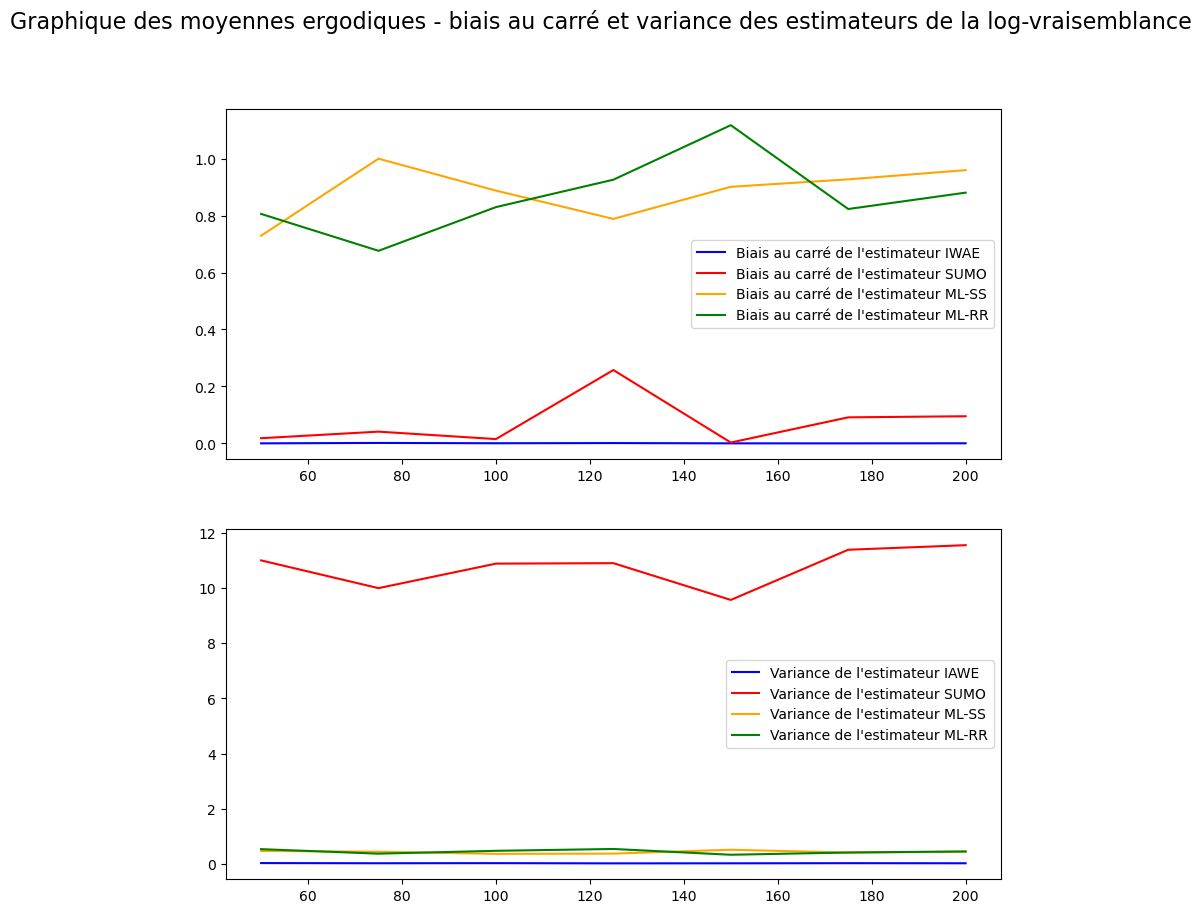

In [166]:
sorted_biais_IWAE_m = sorted(biais_IWAE_m.items())
sorted_biais_SUMO_m = sorted(biais_SUMO_m.items())
sorted_biais_SS_m = sorted(biais_SS_m.items())
sorted_biais_RR_m = sorted(biais_RR_m.items())

sorted_var_IWAE_m = sorted(var_IWAE_m.items())
sorted_var_SUMO_m = sorted(var_SUMO_m.items())
sorted_var_SS_m = sorted(var_SS_m.items())
sorted_var_RR_m = sorted(var_RR_m.items())

m, biais_IAWE = zip(*sorted_biais_IWAE_m)
m, biais_SUMO = zip(*sorted_biais_SUMO_m)
m, biais_SS = zip(*sorted_biais_SS_m)
m, biais_RR = zip(*sorted_biais_RR_m)

m, var_IAWE = zip(*sorted_var_IWAE_m) 
m, var_SUMO = zip(*sorted_var_SUMO_m) 
m, var_SS = zip(*sorted_var_SS_m) 
m, var_RR = zip(*sorted_var_RR_m) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

axs[0].plot(m, np.square(biais_IAWE), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(m, np.square(biais_SUMO), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(m, np.square(biais_SS), 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(m, np.square(biais_RR), 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Graphique des moyennes ergodiques - biais au carré et variance des estimateurs de la log-vraisemblance', fontsize=16)

axs[1].plot(m, var_IAWE, 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(m, var_SUMO, 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(m, var_SS, 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(m, var_RR, 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

plt.show()

# Estimateurs du gradient de la log-vraisemblance

## Comparaison entre estimateurs et vrai gradient au point x

On estime le gradient de la  log-vraisemblance au point $\mathbf{x}$. On prend k=100 pour l'estimateur IAWE.

In [167]:
np.random.seed(589)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=100, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6), decimals=2)))

Vraie valeur du gradient de la log-vraisemblance au point x: [-0.56 -0.14  5.68 -1.59  0.35 -3.65 -1.39 -5.28 -0.74 -1.42 -2.03 -0.48
  1.42  4.72  0.91  4.48  1.94  3.69 -0.3  -4.25]
Estimateur IAWE du gradient de la log-vraisemblance: [-0.04  0.03  1.47 -0.39  0.06 -0.75 -0.22 -1.38 -0.08 -0.35 -0.6   0.03
  0.4   1.3   0.1   0.95  0.42  1.12  0.01 -1.09]
Estimateur SUMO du gradient de la log-vraisemblance: [ 0.19  2.49  4.26 -0.08 -0.27  0.58  0.55 -2.08 -0.21  2.57 -2.21  0.13
  3.75  3.76  2.4   2.88 -1.46  1.73  0.35 -2.49]
Estimateur ML-SS du gradient de la log-vraisemblance: [ 0.43 -0.31  2.6   0.58  0.27 -1.43 -0.24 -0.23 -0.36 -1.36 -0.81 -0.61
  0.14  1.48  0.5   1.59  2.02  1.09 -0.06 -1.56]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 0.31  0.51  1.56 -0.42  0.15 -0.47 -0.53 -0.28  0.26  0.51  0.26  0.05
  0.55  1.69  0.93  1.96  0.4   1.21  0.74 -0.86]


## Procédure de Monte Carlo

Le gradient de la log-vraisemblance ainsi que les différents estimateurs associés sont dans $\mathbb{R}^{20}$. Ainsi, on adapte la définition du biais au carré et de la variance, de sorte à avoir une valeur réelle.

\begin{equation}

    biais_M=\frac{1}{M} \sum_{m=1}^{M} estimateur_m - \nabla_{\theta}l(x;\theta)

\end{equation}

\begin{equation}

    biais^2_M=\lVert biais_M \rVert^2

\end{equation}

\begin{equation}

    Var_M=\frac{1}{M} \sum_{m=1}^{M} \lVert estimateur_m - \frac{1}{M} \sum_{m=1}^{M} estimateur_m \rVert^{2}

\end{equation}

On prend $k=100$ pour l'estimateur IWAE.

In [168]:
def procedure_MC_gradient(M, k, x, theta, A, b):
    m=0
    estimations_IWAE=np.array([])
    estimations_SUMO=np.array([])
    estimations_SS=np.array([])
    estimations_RR=np.array([])


    while m<M:
        gradient_log_vraisemblance_estim_IWAE=importance_sampling_gradientlogvraisemblance(k=k, theta=theta, A=A, b=b, x=x)
        gradient_log_vraisemblance_estim_SUMO=estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6)
        gradient_log_vraisemblance_estim_SS=estimateur_ML_SS_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6)
        gradient_log_vraisemblance_estim_RR=estimateur_ML_RR_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6)

        if m==0:
            estimations_IWAE= np.append(estimations_IWAE, gradient_log_vraisemblance_estim_IWAE)
            estimations_SUMO=np.append(estimations_SUMO, gradient_log_vraisemblance_estim_SUMO)
            estimations_SS=np.append(estimations_SS, gradient_log_vraisemblance_estim_SS)
            estimations_RR=np.append(estimations_RR, gradient_log_vraisemblance_estim_RR)
        
        else:
            estimations_IWAE= np.vstack((estimations_IWAE, gradient_log_vraisemblance_estim_IWAE))
            estimations_SUMO=np.vstack((estimations_SUMO, gradient_log_vraisemblance_estim_SUMO))
            estimations_SS=np.vstack((estimations_SS, gradient_log_vraisemblance_estim_SS))
            estimations_RR=np.vstack((estimations_RR, gradient_log_vraisemblance_estim_RR))
        m+=1
    
    biais_IWAE_M=np.mean(estimations_IWAE, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
    biais_SUMO_M=np.mean(estimations_SUMO, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
    biais_SS_M=np.mean(estimations_SS, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
    biais_RR_M=np.mean(estimations_RR, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)

    squared_biais_IWAE_M=norm(biais_IWAE_M)**2
    squared_biais_SUMO_M=norm(biais_SUMO_M)**2
    squared_biais_SS_M=norm(biais_SS_M)**2
    squared_biais_RR_M=norm(biais_RR_M)**2

    var_IWAE_M=np.mean(norm(estimations_IWAE-np.mean(estimations_IWAE, axis=0)))
    var_SUMO_M=np.mean(norm(estimations_SUMO-np.mean(estimations_SUMO, axis=0)))
    var_SS_M=np.mean(norm(estimations_SS-np.mean(estimations_SS, axis=0)))
    var_RR_M=np.mean(norm(estimations_RR-np.mean(estimations_RR, axis=0)))


    return squared_biais_IWAE_M, squared_biais_SUMO_M, squared_biais_SS_M, squared_biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

On teste la procédure avec $M=50, 75, 100, 125, 150, 175, 200$. Plus M est grand, plus les estimateurs du biais et de la variance sont précis (passé $M >150,200$, la précision n'augmente plus significativement, généralement).

In [169]:
np.random.seed(8554)

choix_M=np.arange(50,225, 25)

squared_biais_IWAE_m={}
squared_biais_SUMO_m={}
squared_biais_SS_m={}
squared_biais_RR_m={}

var_IWAE_m={}
var_SUMO_m={}
var_SS_m={}
var_RR_m={}

for m in choix_M:
    res=procedure_MC_gradient(M=m, k=100, x=x, theta=theta, A=A, b=b)
    
    squared_biais_IWAE_m[m]=res[0]
    squared_biais_SUMO_m[m]=res[1]
    squared_biais_SS_m[m]=res[2]
    squared_biais_RR_m[m]=res[3]

    var_IWAE_m[m]=res[4]
    var_SUMO_m[m]=res[5]
    var_SS_m[m]=res[6]
    var_RR_m[m]=res[7]


C:\Users\yanis\AppData\Local\Temp\ipykernel_37724\2386538657.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(m, biais_IAWE, 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
C:\Users\yanis\AppData\Local\Temp\ipykernel_37724\2386538657.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(m, biais_SUMO, 'b', label="Biais au carré de l'estimateur SUMO", color="red")
C:\Users\yanis\AppData\Local\Temp\ipykernel_37724\2386538657.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(m, biais_SS, 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
C:\U

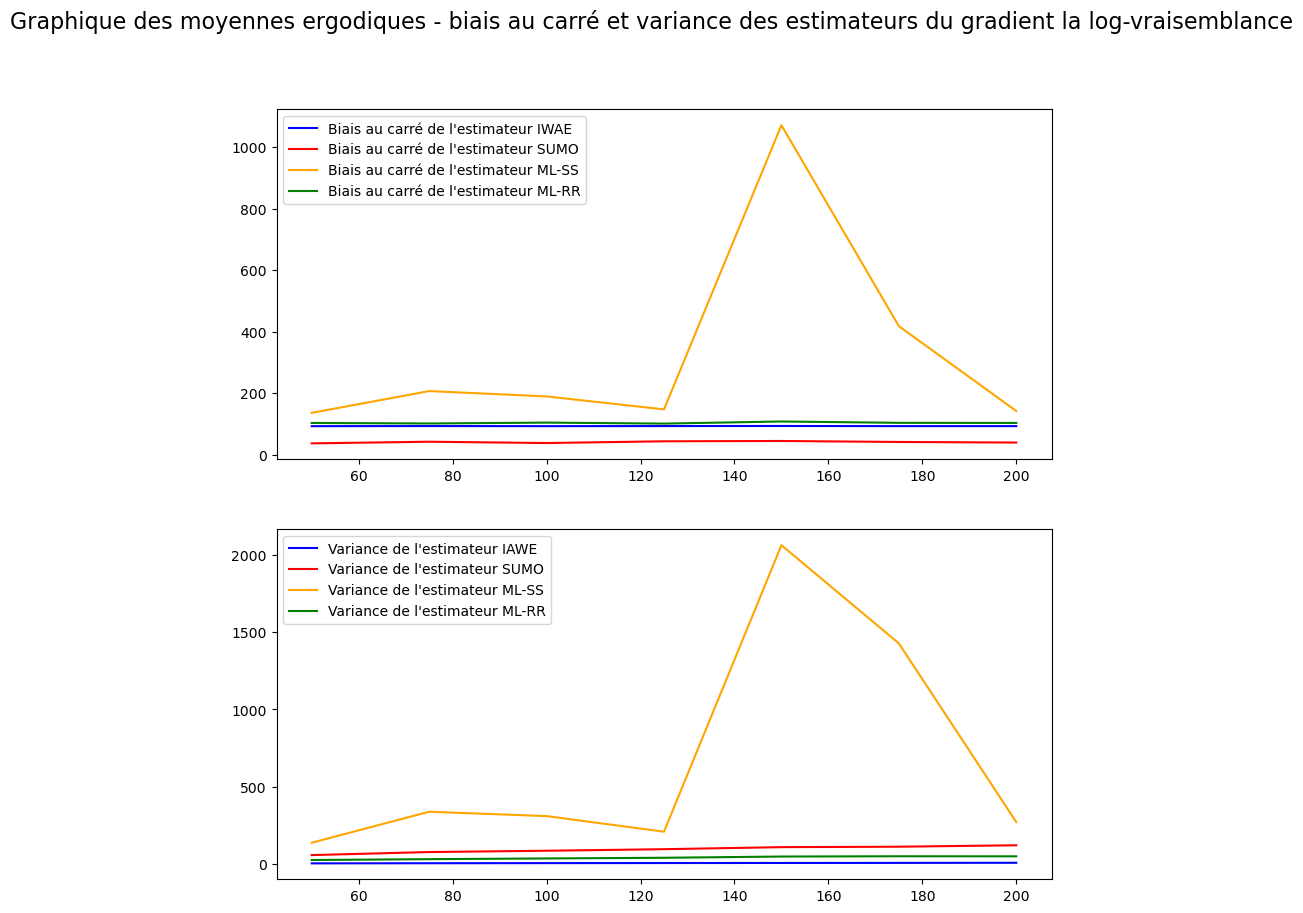

In [170]:
sorted_biais_IWAE_m = sorted(squared_biais_IWAE_m.items())
sorted_biais_SUMO_m = sorted(squared_biais_SUMO_m.items())
sorted_biais_SS_m = sorted(squared_biais_SS_m.items())
sorted_biais_RR_m = sorted(squared_biais_RR_m.items())

sorted_var_IWAE_m = sorted(var_IWAE_m.items())
sorted_var_SUMO_m = sorted(var_SUMO_m.items())
sorted_var_SS_m = sorted(var_SS_m.items())
sorted_var_RR_m = sorted(var_RR_m.items())

m, biais_IAWE = zip(*sorted_biais_IWAE_m)
m, biais_SUMO = zip(*sorted_biais_SUMO_m)
m, biais_SS = zip(*sorted_biais_SS_m)
m, biais_RR = zip(*sorted_biais_RR_m)

m, var_IAWE = zip(*sorted_var_IWAE_m) 
m, var_SUMO = zip(*sorted_var_SUMO_m) 
m, var_SS = zip(*sorted_var_SS_m) 
m, var_RR = zip(*sorted_var_RR_m) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

axs[0].plot(m, biais_IAWE, 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(m, biais_SUMO, 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(m, biais_SS, 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(m, biais_RR, 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Graphique des moyennes ergodiques - biais au carré et variance des estimateurs du gradient la log-vraisemblance', fontsize=16)

axs[1].plot(m, var_IAWE, 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(m, var_SUMO, 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(m, var_SS, 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(m, var_RR, 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

plt.show()